In [1]:
import os
import sys
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error
from alpha_vantage.timeseries import TimeSeries

from data_loader import *
from stats import *
from train_test import *


## Settings

In [107]:
seed = 7
num_train = 80
num_test = 20
num_total = num_train + num_test

window_size = 10
kernel_size = 5

# tickers = [
#     "AMZN", "AAPL", "NVDA", "GME", "MSFT", "META", "AVGO", "NFLX", "GOOG",
#     "AMGN", "JNJ", "UNH", "VKTX", "NVAX", "OCGN", "ABBV", "REGN", "ELAN", 
#     "AAL", "LUV", "JEPI", "SOFI", "ORCL", "PLTR", 
#     # "TSLA", "SOUN", "NIO", "MDB"
# ]

tickers = [
    "AAPL", "MSFT", "AMZN", "TSLA", "NVDA", "META", "GOOGL", "GOOG", "JPM", 
    "V", "UNH", "JNJ", "WMT", "PG", "MA", "HD", "BAC", "DIS", "PYPL", 
    "NFLX", "KO", "PFE", "CSCO", "XOM", "VZ", "INTC", "T", "MRK", "CVX", 
    "NKE", "ORCL", "ABT", "CMCSA",  "MDT", "MCD", "WFC", "LLY", "HON", 
    "QCOM", "AMGN", "TXN", "SBUX", "MMM", "DHR", "BMY", "C", "GS", "CAT", 
    "SPG", "TMO", "LOW", "UPS", "MS", "UNP", "RTX", "AXP", "BLK", "SCHW", 
    "BKNG", "AMT", "F", "DE", "LIN", "ADP", "PLD", "ISRG", "SYK", "GILD", 
    "LMT", "MO", "CL", "MDLZ", "TGT", "USB", "SO", "NEE", "AON", "MMC", 
    "CB", "PGR", "CI", "MET", "AFL", "PRU", "ALL", "TRV", "AIG", "HIG", 
    "LNC", "PFG", "UNM", "L", "CNA", "CINF", "AIZ"
]


#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.mnaual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)


writer = SummaryWriter(log_dir=f"runs/sparsely_connected/{datetime.now().strftime('%Y%m%d_%H%M%S')}")


In [105]:
len(tickers)

95

## Data

In [108]:
X = []
y = []

for ticker in tickers:
    X1, y1 = load_stock_yfinance(ticker, num_t=150)
    X.append(X1)
    y.append(y1)


X = np.stack(X)
y = np.stack(y)


X_train, y_train = setup_cov_tensors(X[..., -num_total: -num_test], y[..., -num_total: -num_test], window_size)
X_test, y_test = setup_cov_tensors(X[..., -num_test-window_size:], y[..., -num_test-window_size:], window_size)


In [109]:
print(X_train.shape)
print(y_train.shape)

torch.Size([70, 95, 3, 10])
torch.Size([70, 95])


## Model

In [110]:
class MultiStockReturnPredictor(nn.Module):
    def __init__(self, per_stock_features, kernel_size, num_outputs, sequence_length):
        super(MultiStockReturnPredictor, self).__init__()
        
        self.per_stock_features = per_stock_features
        convolution_channels = per_stock_features * per_stock_features
        convolution_out = int(convolution_channels * 0.5)
        self.num_stocks = num_outputs  # Number of stocks
        
        # Dynamically create convolutional layers for each stock
        self.conv1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=per_stock_features, out_channels=convolution_channels, kernel_size=kernel_size, stride=1, padding=0),
                nn.Tanh(),
                nn.Conv1d(in_channels=convolution_channels, out_channels=convolution_out, kernel_size=kernel_size, stride=1, padding=0),
                nn.Tanh()
            )
            for _ in range(self.num_stocks)
        ])
        
        # Fully connected layers
        length_after_conv1 = sequence_length - kernel_size + 1
        length_after_conv2 = length_after_conv1 - kernel_size + 1
        fc1_input_size = self.num_stocks * convolution_out * length_after_conv2

        self.fc1 = nn.Linear(fc1_input_size, 100)
        self.fc2 = nn.Linear(100, num_outputs)

        # Initialize weights
        self.apply(self.initialize_weights)

    def initialize_weights(self, module):
        if isinstance(module, nn.Conv1d):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def exponential_smoothing(self, x, alpha=0.3):
        # Apply exponential smoothing along the time dimension
        x_np = x.detach().cpu().numpy()
        smoothed = pd.DataFrame(x_np).ewm(alpha=alpha, axis=2).mean().values
        return torch.tensor(smoothed, dtype=torch.float32, device=x.device)

    def forward(self, x):
        # x shape: [batch_size, num_stocks, per_stock_features, sequence_length]
        stock_outputs = []

        # Apply convolutional layers for each stock
        for i in range(self.num_stocks):
            stock_x = x[:, i, :, :] 
            stock_out = self.conv1[i](stock_x)  # Pass through stock-specific convolutional layers
            stock_outputs.append(stock_out)

        # Concatenate outputs from all stocks
        x_combined = torch.cat(stock_outputs, dim=1) 
        x_combined = x_combined.view(x_combined.size(0), -1)

        # Fully connected layers
        x = torch.tanh(self.fc1(x_combined))
        x = self.fc2(x)

        return x


## Train

In [111]:
model = MultiStockReturnPredictor(X.shape[1], kernel_size, y.shape[0], window_size)

# if cuda:
#     model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)


for epoch in range(1000):
    train(epoch, X_train, y_train, model, optimizer, criterion, writer)
    if epoch % 100 == 0:
        pred, obj = test(epoch, X_test, y_test, model, writer)

writer.close()


Test Loss (MSE): 1.7426
Epoch 100, Loss: 0.0005
Test Loss (MSE): 0.0001
Epoch 200, Loss: 0.0006
Test Loss (MSE): 0.0003
Epoch 300, Loss: 0.0006
Test Loss (MSE): 0.0004
Epoch 400, Loss: 0.0009
Test Loss (MSE): 0.0035
Epoch 500, Loss: 0.0017
Test Loss (MSE): 0.0010
Epoch 600, Loss: 0.0005
Test Loss (MSE): 0.0001
Epoch 700, Loss: 0.0004
Test Loss (MSE): 0.0002
Epoch 800, Loss: 0.0004
Test Loss (MSE): 0.0002
Epoch 900, Loss: 0.0004
Test Loss (MSE): 0.0002
Epoch 1000, Loss: 0.0003


## Stats

In [112]:
pred = np.array(pred)
obj = np.array(obj)

position = np.sign(pred)

pnl = position * obj

pnl_per_stock = np.sum(pnl, axis=0)

pnl_per_date = np.sum(pnl, axis=1)


In [113]:
df_stock = compute_prediction_stats(tickers, pred[:, :], obj[:, :])

df_stock["% return"] = pnl_per_stock * 100
df_stock

,Tickers,Accuracy,StdDevObj,StdDevPred,PredRealization,RMSE,% return
0,AAPL,0.60,0.010168,0.003409,0.000455,0.010578,3.478355
1,MSFT,0.55,0.008876,0.004114,-0.000946,0.010174,0.137409
2,AMZN,0.50,0.009989,0.003428,-0.000006,0.010562,-0.334082
3,TSLA,0.75,0.038690,0.015363,0.006062,0.039328,32.440472
4,NVDA,0.90,0.011011,0.004682,0.002495,0.010945,8.408659
...,...,...,...,...,...,...,...
90,UNM,0.25,0.016258,0.012458,-0.007064,0.024403,-9.710047
91,L,0.25,0.011879,0.007720,-0.004697,0.016530,-6.036434
92,CNA,0.25,0.009797,0.006258,-0.002196,0.012752,-3.386986
93,CINF,0.35,0.009707,0.005735,-0.003860,0.013091,-7.126594


In [30]:
df_stock.to_csv("sprarsely_connected_stock.df", index=False)

In [93]:
df_date = compute_prediction_stats(list(range(pred.shape[0])), pred.T, obj.T)

df_date["% return"] = pnl_per_date * 100
df_date

,Tickers,Accuracy,StdDevObj,StdDevPred,PredRealization,RMSE,% return
0,0,0.375000,0.002943,0.005430,0.000945,0.005280,2.996003
1,1,0.541667,0.003852,0.010784,0.002688,0.008554,4.944691
2,2,0.500000,0.022625,0.011200,0.006708,0.022070,15.430223
3,3,0.416667,0.004729,0.005363,0.002260,0.005184,5.880570
4,4,0.666667,0.011775,0.006465,0.005991,0.010148,16.850910
5,5,0.500000,0.004064,0.004847,0.002184,0.004341,5.877646
6,6,0.333333,0.004307,0.005121,0.002542,0.004329,3.584735
7,7,0.541667,0.035710,0.006463,0.008577,0.034729,36.950165
8,8,0.625000,0.014838,0.007891,0.010767,0.010607,22.935684
9,9,0.583333,0.007626,0.004589,0.004483,0.006169,10.573867


## Plot

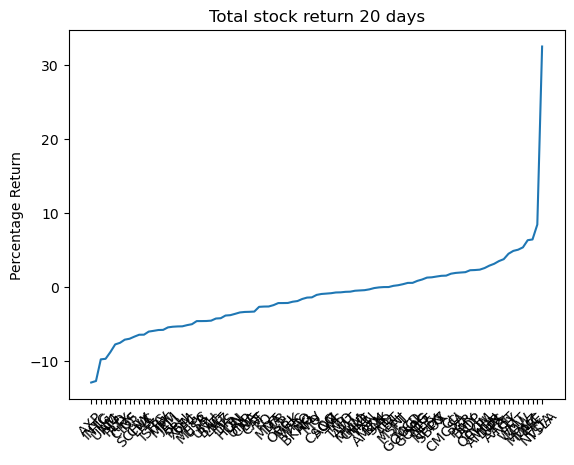

In [114]:
plt.figure()
df_stock = df_stock.sort_values("% return")

plt.ylabel("Percentage Return")
plt.xticks(rotation=45)
plt.title("Total stock return 20 days")
plt.plot(df_stock.Tickers, df_stock["% return"])

plt.savefig("stocks_percent_return.png")

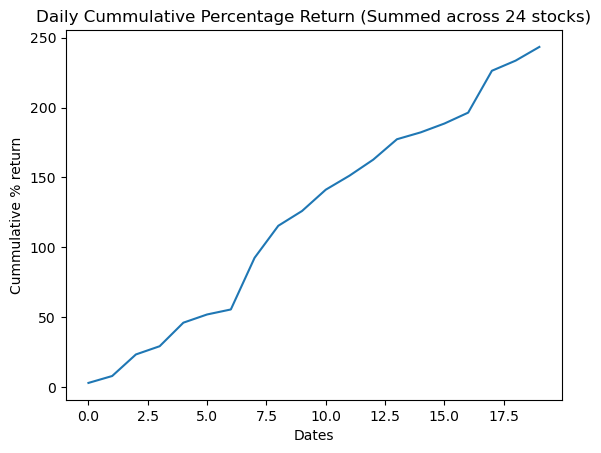

In [115]:
plt.figure()

plt.ylabel("Cummulative % return")
plt.xlabel("Dates")
plt.title("Daily Cummulative Percentage Return (Summed across 24 stocks)")
plt.plot(df_date.Tickers, df_date["% return"].cumsum())

plt.savefig("date_percentage_retrun.png")

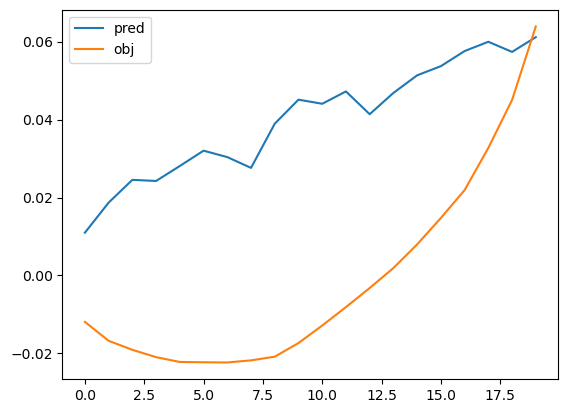

In [34]:
stock_id = 0
_pred = pred[:, stock_id]
_obj = obj[:, stock_id]

obj_sort = np.argsort(_obj)
plt.plot(np.cumsum(_pred[obj_sort]), label="pred")
plt.plot(np.cumsum(_obj[obj_sort]), label="obj")

plt.legend()

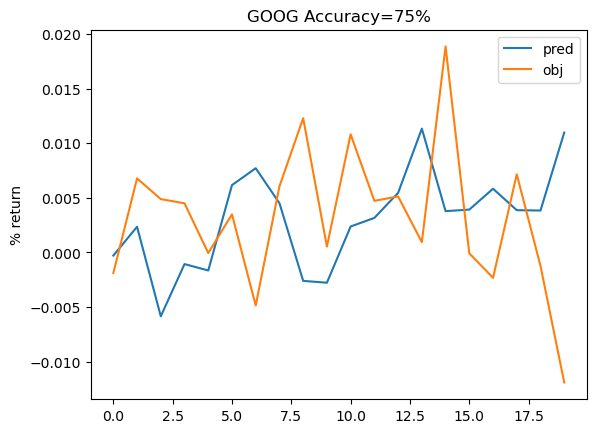

In [35]:
plt.plot((_pred), label="pred")
plt.plot((_obj), label="obj")

plt.title("GOOG Accuracy=75%")
plt.ylabel("% return")
plt.legend()

#plt.savefig("orcl_pred.png")